# Nickolas4 - Efficient Frontier

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import DataReader as dr
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as sco

In [2]:
#Generate portfolio
symbols = ['AAPL', 'MSFT', 'TLT', 'USO', 'GLD', 
           'SPY', 'CAT', 'KO', 'WMT', 'EMB']
asset_count = len(symbols)

In [3]:
#Empty DF to store web data
nickolas4 = pd.DataFrame()

In [4]:
risk_free = dr('^IRX', data_source='yahoo', 
                       start='2010-01-01')['Adj Close']/100
risk_free.tail()

Date
2017-04-24    0.00770
2017-04-25    0.00808
2017-04-26    0.00803
2017-04-27    0.00785
2017-04-28    0.00780
Name: Adj Close, dtype: float64

In [5]:
#Add 10 historic asset returns from Yahoo
for i in symbols:
    nickolas4[i] = dr(i, data_source='yahoo', 
    start='2010-01-01')['Adj Close'].round(2)
nickolas4.columns = symbols

nickolas4.tail()

,AAPL,MSFT,TLT,USO,GLD,SPY,CAT,KO,WMT,EMB
Date,,,,,,,,,,
2017-04-24,143.64,67.53,122.93,10.25,121.48,237.17,96.81,43.28,74.78,114.89
2017-04-25,144.53,67.92,121.45,10.36,120.25,238.55,104.42,43.11,75.05,114.60
2017-04-26,143.68,67.83,122.12,10.26,120.84,238.40,104.66,43.24,75.43,114.58
2017-04-27,143.79,68.27,122.08,10.24,120.39,238.60,102.68,43.01,75.44,114.84
2017-04-28,143.65,68.46,122.35,10.24,120.77,238.08,102.26,43.15,75.18,115.20


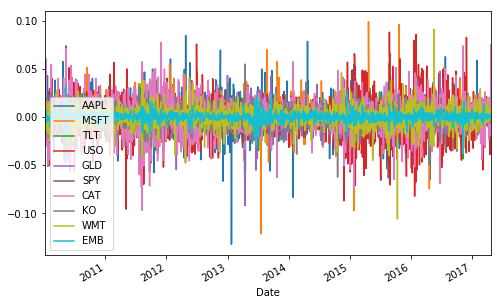

In [6]:
#DF of Logarithim Returns
n4_log = np.log(nickolas4/nickolas4.shift(1))
n4_log.plot(figsize=(8,5))

In [7]:
def statistics(weights):
    ''' Return portfolio statistics.
    
    Parameters
    ==========
    weights : array-like
        weights for different securities in portfolio
    
    Returns
    =======
    pret : float
        expected portfolio return
    pvol : float
        expected portfolio volatility
    pret / pvol : float
        Sharpe ratio for rf=0
    '''
    weights = np.array(weights)
    pret = np.sum(n4_log.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(n4_log.cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol])

In [8]:
weights = np.random.random(len(n4_log.columns))  #generate 10 random numbers between 0 and 1
weights /= np.sum(weights)       #normalize values so that sum = 1 

* Generate vectors of random portfolio weights on a larger scale. 


* For every simulated allocation, we record the resulting portflio return and variance. 


* Of paramount interest to investors is the risk-return profiles that are possible for a given set of securities and their statistical characteristics.

In [9]:
#Iterations
prets = []
pvols = []
for p in range (2500):
    weights = np.random.random(asset_count)
    weights /= np.sum(weights)
    prets.append(np.sum(n4_log.mean() * weights) * 252)
    pvols.append(np.sqrt(np.dot(weights.T, 
                        np.dot(n4_log.cov() * 252, weights))))
prets = np.array(prets)
pvols = np.array(pvols)

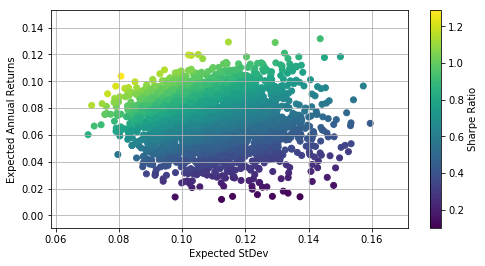

In [10]:
#Monte Carlo Simulation values
plt.figure(figsize=(8,4))
plt.scatter(pvols, prets, c = prets/pvols, marker = 'o')
plt.grid(True)
plt.xlabel("Expected StDev")
plt.ylabel('Expected Annual Returns')
plt.colorbar(label = 'Sharpe Ratio')

# 4.) Efficient Frontier

* The derivation of all optimal portfolios - i,e, all portfolios with minimum volatility for a given target return level (or all portfolios with maximum return for a given level of risk level) - is similar to the previous optimization


* The only difference is that we have to iterate over multiple starting conditions. The approach we take is that we fix a target return level and derive for each such level those portfolio weights that lead to the minimum volatility value. 


* For the optimization, this leads to two conditions: 
        1.) target return level (trets) 
        2.) sum of portfolio weights. 


* The boundary values for each parameter remain the same

In [11]:
#Optimization Constraints
cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})

#Boundary values
bnds = tuple((0, 1) for x in weights)

In [12]:
#Optimization Functions
def min_func_port(weights):
    return statistics(weights)[1]

#Maximize Sharpe Volatility
def maximize_sharpe(weights):
    return -statistics(weights)[2]

#Minimize Variance
def minimize_variance(weights):
    return statistics(weights)[1] ** 2

In [14]:
%%time
trets = np.linspace(0.0, 0.25, 50)
tvols = []
for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = sco.minimize(min_func_port, asset_count * [1. / asset_count,], method='SLSQP',
                       bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

CPU times: user 17.6 s, sys: 52.9 ms, total: 17.7 s
Wall time: 17.8 s


In [15]:
#Optimization Objects
opt_variance = sco.minimize(minimize_variance, asset_count * [1. / asset_count,], method='SLSQP',
                       bounds=bnds, constraints=cons)

opt_sharpe = sco.minimize(maximize_sharpe, asset_count * [1. / asset_count,], method='SLSQP',
                       bounds=bnds, constraints=cons)

* Crosses indicated the optimal portfolios given a certain target return


* The dots are portfolios


* Figure shows two larger stars: 
        
    1.) minimum volatility portfolio (the leftmost portfolio) 

    2.) maximum Sharpe Ratio (top-middle portfolio)
        

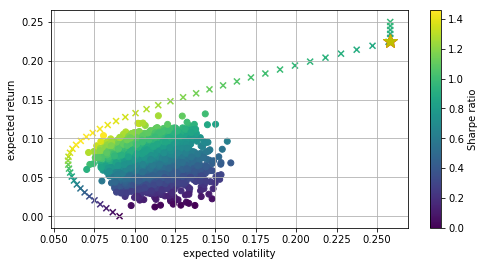

In [17]:
plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets,
            c=prets / pvols, marker='o')
            # random portfolio composition
plt.scatter(tvols, trets,
            c=trets / tvols, marker='x')
            # efficient frontier
plt.plot(statistics(opt_sharpe['x'])[1], statistics(opt_sharpe['x'])[0],
         'r*', markersize=15.0)
            # portfolio with highest Sharpe ratio
plt.plot(statistics(opt_variance['x'])[1], statistics(opt_variance['x'])[0],
         'y*', markersize=15.0)
            # minimum variance portfolio
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')